# Mounting content from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Part 1: Loading and preprocessing the data

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import os
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

tweet_path = "/content/gdrive/My Drive/SentimentTweets.csv"

#Creating the dataframe and converting every uppercase character to lowercase using the str.lower() function.
tweet_df = pd.read_csv(tweet_path).apply(lambda x: x.astype(str).str.lower())

#We will substitute every unwanted character with ' '. Here we remove the URLs.
tweet_df['text'] = tweet_df['text'].apply(lambda y: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', " ", y , flags=re.MULTILINE) )

#Here we remove escape characters such as \n, \x and \u.
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\n', " ", z , flags=re.MULTILINE) )
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\x..', " ", z , flags=re.MULTILINE) )
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\u....', " ", z , flags=re.MULTILINE) )

#We also remove any other remaining symbols by removing every non-alphabetic character.
tweet_df['text'] = tweet_df['text'].apply(lambda k: re.sub("[^a-z]+", " ", k, flags=re.MULTILINE) )

#Now we remove the stopwords.
stop = stopwords.words('english')
tweet_df['text'] = tweet_df['text'].apply(lambda s: ' '.join([item for item in s.split() if item not in stop]))

#Since the dataset is too large, only half of the dataframe will be used for the TF-IDF model. (Otherwise the session crashes from too much RAM usage)
half_size = (int)(tweet_df.shape[0]/2)
tweet_df = tweet_df[:half_size]

#Splitting the dataframe into train and test subsets.
train_set, test_set = train_test_split(tweet_df, test_size=0.8, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Part 2: Stemming, lemmatization and initializing the TF-IDF array

In [ ]:
#Showing the 'text' column of the training set after the preprocessing.
train_set['text']

93083                        supastartorch think aggressive
420375              stop thinking hmm want college tomorrow
338030                      waipahu grad come congrats sean
263294    diy home spa face masque strawberry walnut she...
424616        yummy chocolate answers lyfz problemz twitter
                                ...                        
110268    zoeox iii breathe easy legends ooh thank reall...
259178                           grienke another loss today
365838    send copy email prime minister canada among ot...
131932    full energy today spent morning singing along ...
121958    demolished peanut butter honey toast wonderful...
Name: text, Length: 128000, dtype: object

# Stemming

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import warnings
warnings.filterwarnings('ignore') 

#Objects needed for the stemming.
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()

#Defining a stem_sentences function that will stem our text and return it in string format.
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

#Stemming the text.
train_set['stemmed_text'] = train_set['text'].apply(stem_sentences)
test_set['stemmed_text'] = test_set['text'].apply(stem_sentences)

#Showing the 'text' column of the training set after stemming.
train_set['stemmed_text']

93083                           supastartorch think aggress
420375                  stop think hmm want colleg tomorrow
338030                       waipahu grad come congrat sean
263294    diy home spa face masqu strawberri walnut shel...
424616            yummi chocol answer lyfz problemz twitter
                                ...                        
110268    zoeox iii breath easi legend ooh thank realli ...
259178                              grienk anoth loss today
365838    send copi email prime minist canada among othe...
131932    full energi today spent morn sing along fall b...
121958     demolish peanut butter honey toast wonder sticki
Name: stemmed_text, Length: 128000, dtype: object

# Lemmatization

In [ ]:
nltk.download('wordnet')

#Objects needed for the lemmatization.
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Defining a lemmatize function that will lemmatize our text and return it in string format.
def lemmatize(text):
    string_list = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    list_to_str = ' '.join([str(element) for element in string_list])
    return list_to_str

#Performing lemmatization on the stemmed text.
train_set['lemmatized_text'] = train_set['stemmed_text'].apply(lemmatize)
test_set['lemmatized_text'] = test_set['stemmed_text'].apply(lemmatize)

#Showing the lemmatized text of the training set.
train_set['lemmatized_text']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


93083                           supastartorch think aggress
420375                  stop think hmm want colleg tomorrow
338030                       waipahu grad come congrat sean
263294    diy home spa face masqu strawberri walnut shel...
424616            yummi chocol answer lyfz problemz twitter
                                ...                        
110268    zoeox iii breath easi legend ooh thank realli ...
259178                              grienk anoth loss today
365838    send copi email prime minist canada among othe...
131932    full energi today spent morn sing along fall b...
121958     demolish peanut butter honey toast wonder sticki
Name: lemmatized_text, Length: 128000, dtype: object

# Initializing the TF-IDF array

In [ ]:
#Initializing TF-IDF array with unigrams and bigrams. Max_features had to be reduced for the tensor coversion.
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
tfs_train = tfidf.fit_transform(train_set['lemmatized_text'])
tfs_test = tfidf.transform(test_set['lemmatized_text'])

#Getting the labels.
Y_train = train_set['target']
Y_test = test_set['target']

# Part 4: Converting to PyTorch and Creating the Model

# Converting the TF-IDF array

In [ ]:
import scipy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

#Converting the TF-IDF array to PyTorch tensor format.
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(tfs_train)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(tfs_test)).float()

# Converting the Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Encoding the labels.
le = LabelEncoder().fit(Y_train)
Y_train = le.transform(Y_train)
Y_test = le.transform(Y_test)

#And converting to PyTorch tensor format.
y_train = torch.tensor(Y_train)
y_test = torch.tensor(Y_test)

# Creating the Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

#Defining the Feed Forward TF-IDF Model. Commentary about the choices of the dimensions, activation functions etc can be seen in the ReadMe file.
class FeedForwardTF_IDFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardTF_IDFModel, self).__init__()
        
        #Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        #Non-linearity
        self.tanh1 = nn.Tanh()

        #Linear function 2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        #Non-linearity 2
        self.tanh2 = nn.Tanh()

        #Linear function 3 (readout)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function  
        out = self.fc1(x)

        # Non-linearity  
        out = self.tanh1(out)

        # Linear function 2
        out = self.fc2(out)

        #Non-linearity 2
        out = self.tanh2(out)

        # Linear function (readout) 
        out = self.fc3(out)

        return out


input_dim = x_train.shape[1] #Input size is the features of the TF-IDF array.
hidden_dim = 100 #'Random' number for the hidden dimensions.
output_dim = 2 

#Initializing the model.
model = FeedForwardTF_IDFModel(input_dim, hidden_dim, output_dim)

#Initializing the Loss Function and the Optimizer.
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Part 5: Training the model and getting scores

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
train_losses = []
test_losses = []
test_accuracies = []

epochs = 25
predictions = torch.empty(len(y_test),1)
for e in range(epochs): #Training the model for 25 epochs.
    
    optimizer.zero_grad()

    output = model.forward(x_train)
    loss = loss_function(output, y_train)
    loss.backward()
    
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    optimizer.step()

    #Turning off gradients for test validation, saves memory and computations.
    with torch.no_grad():

        model.eval()
        log_ps = model(x_test)
        test_loss = loss_function(log_ps, y_test)
        test_losses.append(test_loss)

        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == y_test.view(*top_class.shape)
        
        #Getting precision, recall and f1 scores.
        prec_score_test = precision_score(top_class, y_test, average = 'weighted')
        rec_score_test = recall_score(top_class, y_test, average = 'weighted')
        f1_score_test = f1_score(top_class, y_test, average = 'weighted')
        predictions = top_class


        test_accuracy = torch.mean(equals.float())
        test_accuracies.append(test_accuracy)

    model.train()

    print(f"Epoch: {e+1}/{epochs}.. ",
          f"Training Loss: {train_loss:.3f}.. ",
          f"Test Loss: {test_loss:.3f}.. ",
          f"Test Accuracy: {test_accuracy:.3f}")

#More discussion about the scores and comparisons with the other models can be seen in the ReadMe file.
print()
print("Printing scores for Precision, Recall and F1-Measure")
print("Average accuracy using Precision : {}%".format(round(prec_score_test*100,2)))
print("Average accuracy using Recall : {}%".format(round(rec_score_test*100,2)))
print("Average accuracy using F1-Measure: {}%".format(round(f1_score_test*100,2)))

Epoch: 1/25..  Training Loss: 0.693..  Test Loss: 0.691..  Test Accuracy: 0.541
Epoch: 2/25..  Training Loss: 0.691..  Test Loss: 0.688..  Test Accuracy: 0.529
Epoch: 3/25..  Training Loss: 0.688..  Test Loss: 0.684..  Test Accuracy: 0.620
Epoch: 4/25..  Training Loss: 0.683..  Test Loss: 0.678..  Test Accuracy: 0.681
Epoch: 5/25..  Training Loss: 0.677..  Test Loss: 0.671..  Test Accuracy: 0.695
Epoch: 6/25..  Training Loss: 0.670..  Test Loss: 0.663..  Test Accuracy: 0.691
Epoch: 7/25..  Training Loss: 0.662..  Test Loss: 0.653..  Test Accuracy: 0.691
Epoch: 8/25..  Training Loss: 0.652..  Test Loss: 0.642..  Test Accuracy: 0.692
Epoch: 9/25..  Training Loss: 0.640..  Test Loss: 0.630..  Test Accuracy: 0.696
Epoch: 10/25..  Training Loss: 0.628..  Test Loss: 0.618..  Test Accuracy: 0.697
Epoch: 11/25..  Training Loss: 0.615..  Test Loss: 0.605..  Test Accuracy: 0.698
Epoch: 12/25..  Training Loss: 0.602..  Test Loss: 0.593..  Test Accuracy: 0.701
Epoch: 13/25..  Training Loss: 0.589.

# Part 6: Choosing the Final Model

The TF-IDF model was the 'chosen one'. Although the other models gave slightly better scores, the TF-IDF model could be trained faster so this gave an option to add more epochs, which as a result made the visualization of Loss vs Epochs a bit more interesting. Also, in the TF-IDF model the test accuracy actually increases with each epoch, which shows an interesting increase in the learning curve. The other models, however, already start off with a rather high accuracy in the test set.

# Plotting Loss vs Epochs

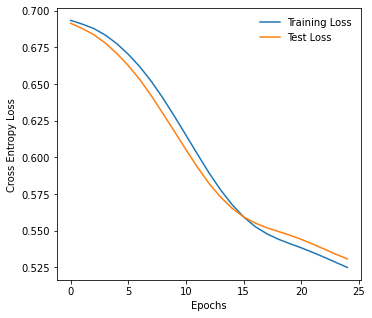

In [ ]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))
ax = plt.subplot(121)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False);

# Plotting the ROC curve

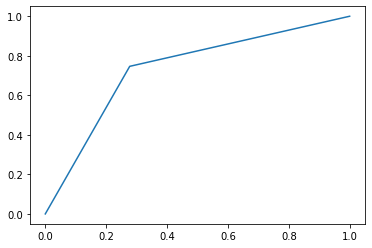

AUC: 73.46%


In [ ]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)

#Plot ROC curve
plt.plot(fpr,tpr)
plt.show() 

#Print AUC score
auc = np.trapz(tpr,fpr)
print('AUC: {}%'.format(round(auc*100,2))) 

A few comments about the plots:

In the ROC curve, we can see the expected curve for an AUC score of ~73%, which was also given from the other scores too. 

In the Loss vs Epochs, we can see that the loss starts off quite high, but as the epochs progress the loss decreases. Which shows that the model actually learns better with each epoch. Interestingly, the training loss appears to be lower than the test loss after about 15 epochs. This might be a slight case of overfitting, or a different learning rate could give more consistent results.

# Getting scores from Logistic Regression from Homework 1

In [ ]:
from sklearn.metrics import classification_report

#Performing the classification. 
reg_model = LogisticRegression()
reg_model.fit(tfs_train, Y_train)
y_test_pred = reg_model.predict(tfs_test)

#The classification report will give us the scores for precision, recall and F1 metrics.
print(classification_report(Y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74    255495
           1       0.73      0.77      0.75    256505

    accuracy                           0.74    512000
   macro avg       0.75      0.74      0.74    512000
weighted avg       0.74      0.74      0.74    512000



We can see that the scores are quite close (if not slightly better) to the ones given from the Feed Forward model. Given the fact the Feed Forward Model is quite simplistic, this should be expected. Probably with the use of a few different hyper-parameters, we could achieve higher scores. But to get even higher scores, we'll probably need a more sophisticated model. To see a comparison of the two models, you can view the ReadMe file.

Note: It should be noted that the scores from the Logistic Regression are not the exact same from HomeWork 1. That's because the dataset could not be used in its entirety in this assignment.